In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load MinWage variable

In [75]:
data = pd.read_csv("./minimum wage.csv") 
data['Effective Date'] = pd.to_datetime(data['Effective Date'], format='%d-%b-%y')
data = data.sort_values(by='Effective Date')

# Remove $ symbol and convert Minimum Wage to float
data['Minimum Wage'] = data['Minimum Wage'].replace('[\$,]', '', regex=True).astype(float)

# Step 2: Generate a daily date range
daily_range = pd.date_range(start='2003-01-01', end='2024-09-01', freq='D')
daily_df = pd.DataFrame({'date': daily_range})

# Step 3: Forward-fill minimum wage values
# Set the Effective Date as index to align with the daily date range
data = data.set_index('Effective Date')

# Merge with the daily date range
daily_df = daily_df.merge(data[['Minimum Wage']], how='left', left_on='date', right_index=True)

# Forward-fill and backward-fill to propagate values to all days
daily_df['MinWage'] = daily_df['Minimum Wage'].ffill().bfill()

# Set minimum wage to $8.00 before 2011-05-01
daily_df.loc[daily_df['date'] < '2011-05-01', 'MinWage'] = 8.00

# Drop the original 'Minimum Wage' column
daily_df = daily_df.drop(columns=['Minimum Wage'])

# Step 4: Display the first few rows of the daily DataFrame
print(daily_df.head(10))

        date  MinWage
0 2003-01-01      8.0
1 2003-01-02      8.0
2 2003-01-03      8.0
3 2003-01-04      8.0
4 2003-01-05      8.0
5 2003-01-06      8.0
6 2003-01-07      8.0
7 2003-01-08      8.0
8 2003-01-09      8.0
9 2003-01-10      8.0


## load crime_number variable

In [76]:
# Step 1: Load the crime data
crime_data = pd.read_csv("./crimedata_csv_AllNeighbourhoods_AllYears/crimedata_csv_AllNeighbourhoods_AllYears.csv")  # Replace with the actual path

# Step 2: Create a daily date column
crime_data['date'] = pd.to_datetime(crime_data[['YEAR', 'MONTH', 'DAY']])

# Step 3: Group by date to count daily crime numbers
daily_crime_counts = crime_data.groupby('date').size().reset_index(name='crime_number')

# Step 4: Merge daily crime data with the daily_df
daily_df = daily_df.merge(daily_crime_counts, how='left', on='date')

# Step 5: Fill missing crime numbers with 0 (days with no reported crimes)
daily_df['crime_number'] = daily_df['crime_number'].fillna(0)

# Step 6: Verify the merged DataFrame
print(daily_df.head(1000))

          date  MinWage  crime_number
0   2003-01-01      8.0           216
1   2003-01-02      8.0           157
2   2003-01-03      8.0           179
3   2003-01-04      8.0           157
4   2003-01-05      8.0           130
..         ...      ...           ...
995 2005-09-22      8.0           127
996 2005-09-23      8.0           150
997 2005-09-24      8.0           129
998 2005-09-25      8.0           139
999 2005-09-26      8.0           154

[1000 rows x 3 columns]


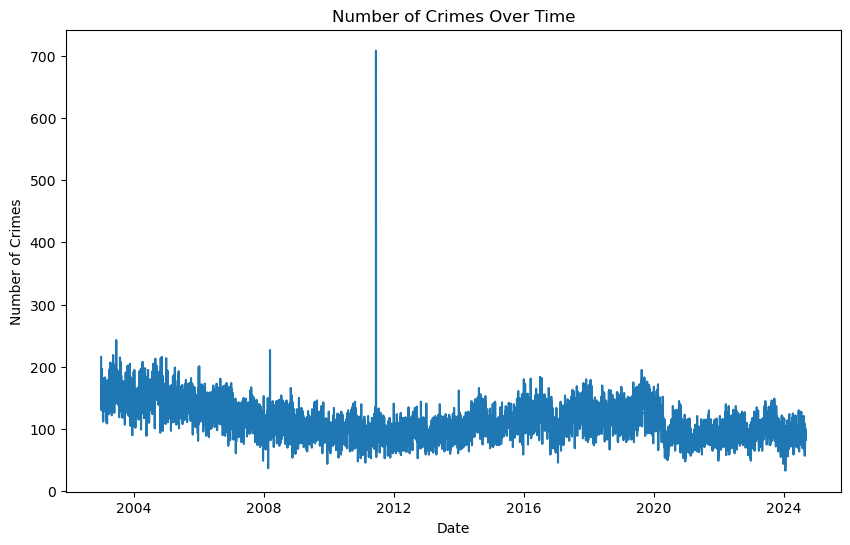

In [77]:
# plot crime number over time
plt.figure(figsize=(10, 6))
plt.plot(daily_df['date'], daily_df['crime_number'])
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes Over Time')
plt.show()


## Remove extreme value in the diagram

Highest crime number found at index: 3087, date: 2011-06-15 00:00:00, value: 708
Value at index 3087 replaced with the average of its neighbors.


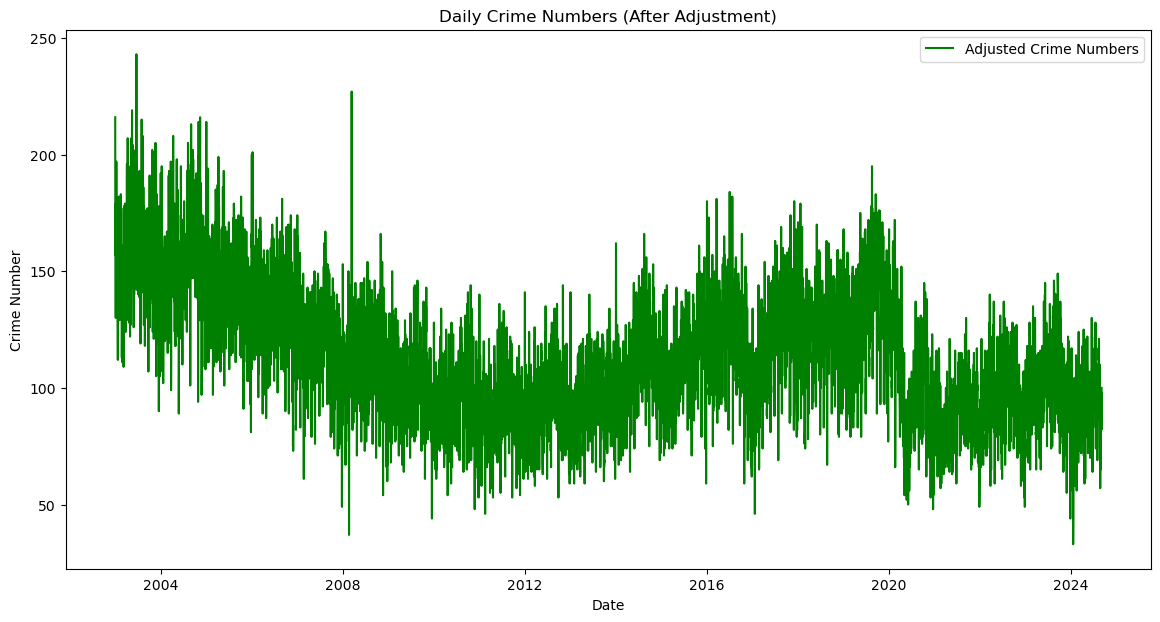

In [78]:
max_index = daily_df['crime_number'].idxmax()
max_value = daily_df.loc[max_index, 'crime_number']
max_date = daily_df.loc[max_index, 'date']

print(f"Highest crime number found at index: {max_index}, date: {max_date}, value: {max_value}")

# Step 3: Replace the highest value with the average of its neighbors
if max_index > 0 and max_index < len(daily_df) - 1:  # Ensure it has neighbors
    daily_df.at[max_index, 'crime_number'] = (
        daily_df.loc[max_index - 1, 'crime_number'] + daily_df.loc[max_index + 1, 'crime_number']
    ) / 2
    print(f"Value at index {max_index} replaced with the average of its neighbors.")

# Step 4: Re-plot the adjusted data
plt.figure(figsize=(14, 7))
plt.plot(daily_df['date'], daily_df['crime_number'], label="Adjusted Crime Numbers", color="green")
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Daily Crime Numbers (After Adjustment)")
plt.legend()
plt.show()

In [79]:
# Step 1: Load the CPI data
cpi_data = pd.read_csv("./1810000601-eng (1).csv", header=0, index_col=0)
cpi_data = cpi_data.T
cpi_data = cpi_data.rename(columns={"All-items 8": "CPI"})

# Step 2: Format the CPI data
cpi_data = cpi_data.reset_index().rename(columns={"index": "date"})
cpi_data['date'] = pd.to_datetime(cpi_data['date'], format='%b-%y')
cpi_data = cpi_data[['date', 'CPI']]

# Step 3: Create a daily date range and forward-fill the CPI values
cpi_data = cpi_data.set_index('date')
daily_cpi_data = cpi_data.reindex(pd.date_range(start=daily_df['date'].min(), 
                                                end=daily_df['date'].max(), 
                                                freq='D')).ffill().reset_index()
daily_cpi_data.columns = ['date', 'CPI']  # Rename columns to match the main DataFrame

# Step 4: Merge the CPI data with `daily_df`
daily_df = daily_df.merge(daily_cpi_data, how='left', on='date')

# Step 5: Verify the merge
print(daily_df.head())
print(daily_df.tail())




        date  MinWage  crime_number    CPI
0 2003-01-01      8.0         216.0  102.4
1 2003-01-02      8.0         157.0  102.4
2 2003-01-03      8.0         179.0  102.4
3 2003-01-04      8.0         157.0  102.4
4 2003-01-05      8.0         130.0  102.4
           date  MinWage  crime_number    CPI
7910 2024-08-28     17.4          90.0  161.3
7911 2024-08-29     17.4          90.0  161.3
7912 2024-08-30     17.4          98.0  161.3
7913 2024-08-31     17.4          82.0  161.3
7914 2024-09-01     17.4         100.0  161.3


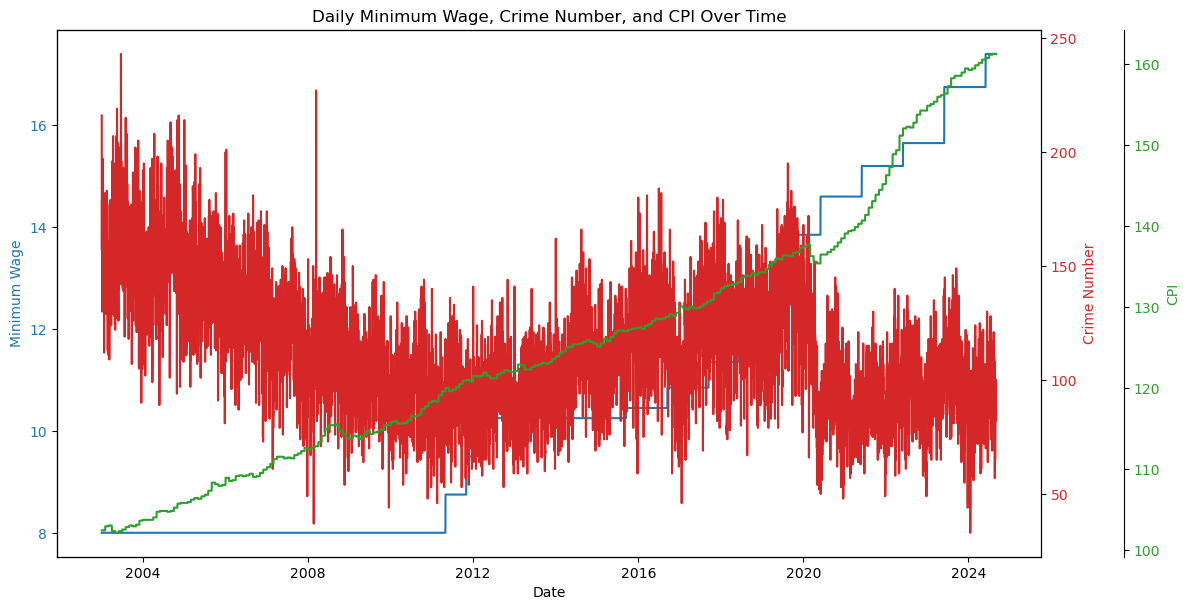

In [80]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Minimum Wage
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Minimum Wage', color=color)
ax1.plot(daily_df['date'], daily_df['MinWage'], color=color, label="Minimum Wage")
ax1.tick_params(axis='y', labelcolor=color)

# Plot Crime Number on the second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Crime Number', color=color)
ax2.plot(daily_df['date'], daily_df['crime_number'], color=color, label="Crime Number")
ax2.tick_params(axis='y', labelcolor=color)

# Plot CPI on the third y-axis
ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.set_ylabel('CPI', color=color)
ax3.plot(daily_df['date'], daily_df['CPI'], color=color, label="CPI")
ax3.tick_params(axis='y', labelcolor=color)

# Tight layout and title
fig.tight_layout()
plt.title('Daily Minimum Wage, Crime Number, and CPI Over Time')

# Show the plot
plt.show()


## Load temperature variable

In [81]:
# Convert temperature data to datetime
temperature_data = pd.read_csv("./temperature.csv", header=None, names=["date", "temperature"])
temperature_data['date'] = pd.to_datetime(temperature_data['date'], format='%Y-%m-%d')

# Merge the temperature data with daily data
daily_df = pd.merge(daily_df, temperature_data, how='left', on='date')

# Backward fill to propagate monthly temperature values to daily rows
daily_df['temperature'] = daily_df['temperature'].bfill()

# Verify the result
print(daily_df.head())


        date  MinWage  crime_number    CPI  temperature
0 2003-01-01      8.0         216.0  102.4          7.2
1 2003-01-02      8.0         157.0  102.4          5.5
2 2003-01-03      8.0         179.0  102.4          5.5
3 2003-01-04      8.0         157.0  102.4          5.5
4 2003-01-05      8.0         130.0  102.4          5.5


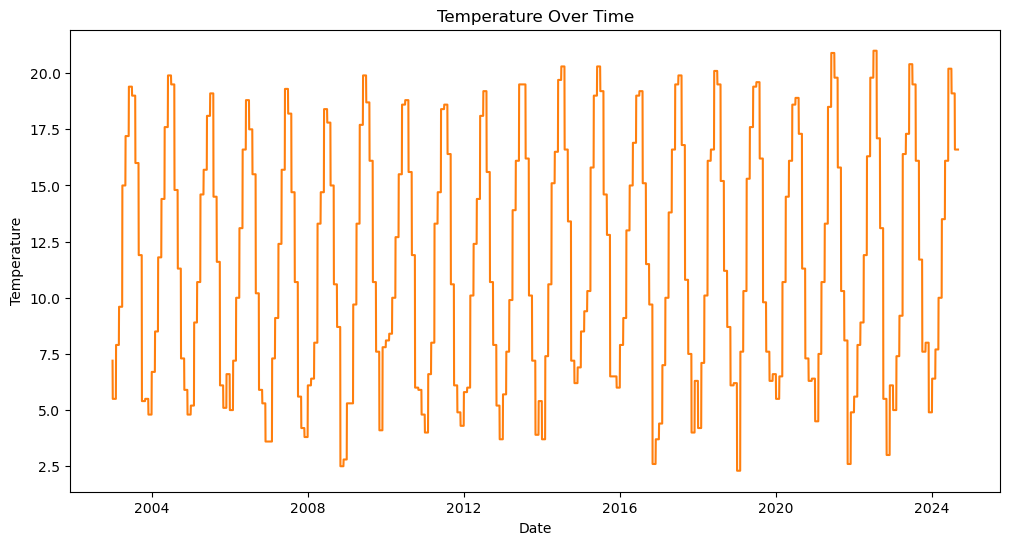

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(daily_df['date'], daily_df['temperature'], color='tab:orange')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()


## Loaded police officer ratio and weighted clearance rate

In [83]:
# Load and preprocess the police data
police_data = pd.read_csv("./unemployment_police.csv")  
police_data['Date'] = pd.to_datetime(police_data['Date'])
police_data.rename(columns={'Date': 'date'}, inplace=True)

# Merge police data with the daily data
daily_df = pd.merge(daily_df, police_data, how='left', on='date')

# Forward fill to propagate monthly values to daily rows
daily_df[['Police officers per 100,000 population', 'Weighted clearance rate', 'Vancouver Unemployment Rate']] = \
    daily_df[['Police officers per 100,000 population', 'Weighted clearance rate', 'Vancouver Unemployment Rate']].ffill()

# Verify the result
print(daily_df.head(1000))


          date  MinWage  crime_number    CPI  temperature  \
0   2003-01-01      8.0         216.0  102.4          7.2   
1   2003-01-02      8.0         157.0  102.4          5.5   
2   2003-01-03      8.0         179.0  102.4          5.5   
3   2003-01-04      8.0         157.0  102.4          5.5   
4   2003-01-05      8.0         130.0  102.4          5.5   
..         ...      ...           ...    ...          ...   
995 2005-09-22      8.0         127.0  108.3         11.6   
996 2005-09-23      8.0         150.0  108.3         11.6   
997 2005-09-24      8.0         129.0  108.3         11.6   
998 2005-09-25      8.0         139.0  108.3         11.6   
999 2005-09-26      8.0         154.0  108.3         11.6   

     Police officers per 100,000 population  Weighted clearance rate  \
0                                     204.2                    22.74   
1                                     204.2                    22.74   
2                                     204.2        

In [84]:
import pandas as pd

# Function to generate a data description table for all variables
def generate_data_description(df):
    # Basic Statistics using describe()
    stats = df.describe(include='all').transpose()

    # Count unique values
    stats['unique_values'] = df.nunique()

    # Reorder columns for clarity
    stats = stats[['count', 'unique_values', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    # Rename index to column names
    stats.index.name = 'column_name'

    return stats

# Generate the data description table for merged_df
data_description = generate_data_description(daily_df)

# Display the data description table
data_description


/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_45159/4102228470.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  stats = df.describe(include='all').transpose()


,count,unique_values,mean,std,min,25%,50%,75%,max
column_name,,,,,,,,,
date,7915,7915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinWage,7915.0,14,10.74566,2.931028,8.0,8.0,10.25,12.65,17.4
crime_number,7915.0,171,112.850095,27.483458,33.0,92.5,109.0,130.0,243.0
CPI,7915.0,206,125.452773,15.558932,102.1,113.7,123.2,135.4,161.3
temperature,7915.0,136,11.452647,5.353086,2.3,6.5,10.7,16.2,21.0
"Police officers per 100,000 population",7915.0,20,204.208566,15.347711,183.8,191.5,199.1,216.9,234.4
Weighted clearance rate,7915.0,19,26.340169,2.259854,22.74,24.53,25.33,27.62,30.85
Vancouver Unemployment Rate,7915.0,56,6.161807,1.572344,3.2,4.8,6.5,7.0,14.2


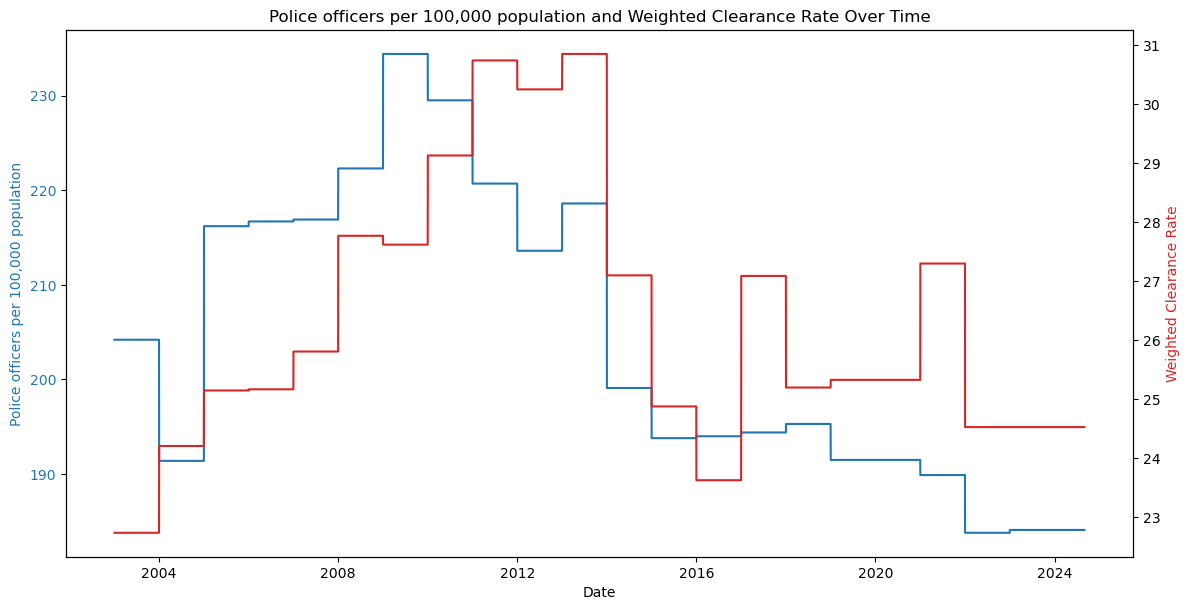

In [85]:
# visualize Police officers per 100,000 population and weighted clearance rate over time
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Police officers per 100,000 population', color=color)
ax1.plot(daily_df['date'], daily_df['Police officers per 100,000 population'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'

ax2.set_ylabel('Weighted Clearance Rate', color=color)
ax2.plot(daily_df['date'], daily_df['Weighted clearance rate'], color=color)

fig.tight_layout()
plt.title('Police officers per 100,000 population and Weighted Clearance Rate Over Time')
plt.show()

In [86]:
merged_df_sarima = daily_df.copy()
merged_df_xgb = daily_df.copy()

## Method 1: SARIMA 

In [87]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import matplotlib.pyplot as plt
# import pandas as pd

# # Copy the daily_df to work with SARIMA
# merged_df_sarima = daily_df.copy()

# # Step 1: Filter data to include only dates before March 1, 2020 (public health emergency)
# pre_emergency_data = merged_df_sarima[merged_df_sarima['date'] < '2020-03-01']
# crime_series_sarima = pre_emergency_data.set_index('date')['crime_number']
# crime_series_sarima = crime_series_sarima.asfreq('D')  # Daily frequency for SARIMA

# # Step 2: Define and fit the SARIMA model
# model_sarima = SARIMAX(crime_series_sarima, order=(1, 0, 0), seasonal_order=(1, 1, 1, 365))  # Assuming yearly seasonality
# sarima_model = model_sarima.fit(disp=False)

# # Step 3: Forecast crime numbers from March 1, 2020 to the end of the dataset
# forecast_start = '2020-03-01'
# forecast_end = merged_df_sarima['date'].max()
# forecast_sarima = sarima_model.predict(start=forecast_start, end=forecast_end, dynamic=True)

# # Step 4: Convert forecast to DataFrame and merge back with merged_df_sarima
# forecast_df_sarima = forecast_sarima.reset_index()
# forecast_df_sarima.columns = ['date', 'predicted_crime_number_sarima']
# merged_df_sarima = pd.merge(merged_df_sarima, forecast_df_sarima, how='left', on='date')

# # Step 5: Plot actual vs. predicted crime numbers using only merged_df_sarima
# emergency_date = pd.to_datetime('2020-03-01')
# plt.figure(figsize=(14, 7))
# plt.plot(merged_df_sarima['date'], merged_df_sarima['crime_number'], label="Actual Crime Number", color="blue")
# plt.plot(merged_df_sarima['date'], merged_df_sarima['predicted_crime_number_sarima'], label="Predicted Crime Number (SARIMA)", color="red", linestyle="--")
# plt.axvline(x=emergency_date, color='green', linestyle='--', label='Public Health Emergency')
# plt.xlabel("Date")
# plt.ylabel("Crime Number")
# plt.title("Actual vs Predicted Crime Numbers (SARIMA)")
# plt.legend()
# plt.show()

# # Step 6: Calculate and print the difference to quantify the impact
# merged_df_sarima['crime_difference_sarima'] = merged_df_sarima['crime_number'] - merged_df_sarima['predicted_crime_number_sarima']
# print(merged_df_sarima[['date', 'crime_number', 'predicted_crime_number_sarima', 'crime_difference_sarima']].tail(5))


In [88]:
# from sklearn.metrics import mean_squared_error, r2_score
# from scipy.stats import ttest_rel
# import numpy as np

# print("Results from the SARIMA model:")

# # Step 1: Select actual and predicted values
# actual_crime = merged_df_sarima['crime_number']
# predicted_crime = merged_df_sarima['predicted_crime_number_sarima']

# # Drop NaN values to avoid computation errors
# valid_indices = actual_crime.notna() & predicted_crime.notna()
# actual_crime = actual_crime[valid_indices]
# predicted_crime = predicted_crime[valid_indices]

# # Step 2: Calculate RMSE
# rmse = np.sqrt(mean_squared_error(actual_crime, predicted_crime))
# print(f"RMSE: {rmse:.2f}")

# # Step 3: Calculate R-squared
# r2 = r2_score(actual_crime, predicted_crime)
# print(f"R-squared: {r2:.2f}")

# # Step 4: Perform Hypothesis Test
# t_stat, p_value = ttest_rel(actual_crime, predicted_crime)
# alpha = 0.05
# if p_value < alpha:
#     print(f"The difference is statistically significant (p={p_value:.3f}).")
#     print("This suggests a correlation between the public health emergency and decreased crime numbers.")
# else:
#     print(f"The difference is not statistically significant (p={p_value:.3f}).")
#     print("There is insufficient evidence to conclude a correlation between the public health emergency and crime numbers.")

# # Step 5: Calculate average percent difference after March 1, 2020
# post_emergency_actual = merged_df_sarima.loc[merged_df_sarima['date'] >= '2020-03-01', 'crime_number']
# post_emergency_predicted = merged_df_sarima.loc[merged_df_sarima['date'] >= '2020-03-01', 'predicted_crime_number_sarima']

# # Ensure no NaN values for calculation
# valid_indices_post = post_emergency_actual.notna() & post_emergency_predicted.notna()
# post_emergency_actual = post_emergency_actual[valid_indices_post]
# post_emergency_predicted = post_emergency_predicted[valid_indices_post]

# percent_diff = ((post_emergency_actual - post_emergency_predicted) / post_emergency_actual).mean() * 100
# print(f"Average percent difference after the public health emergency: {percent_diff:.2f}%")


## Method 2: XGBoost

/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_45159/291095162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_45159/291095162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_45159/291095162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a 

Validation MAPE: 12.87%


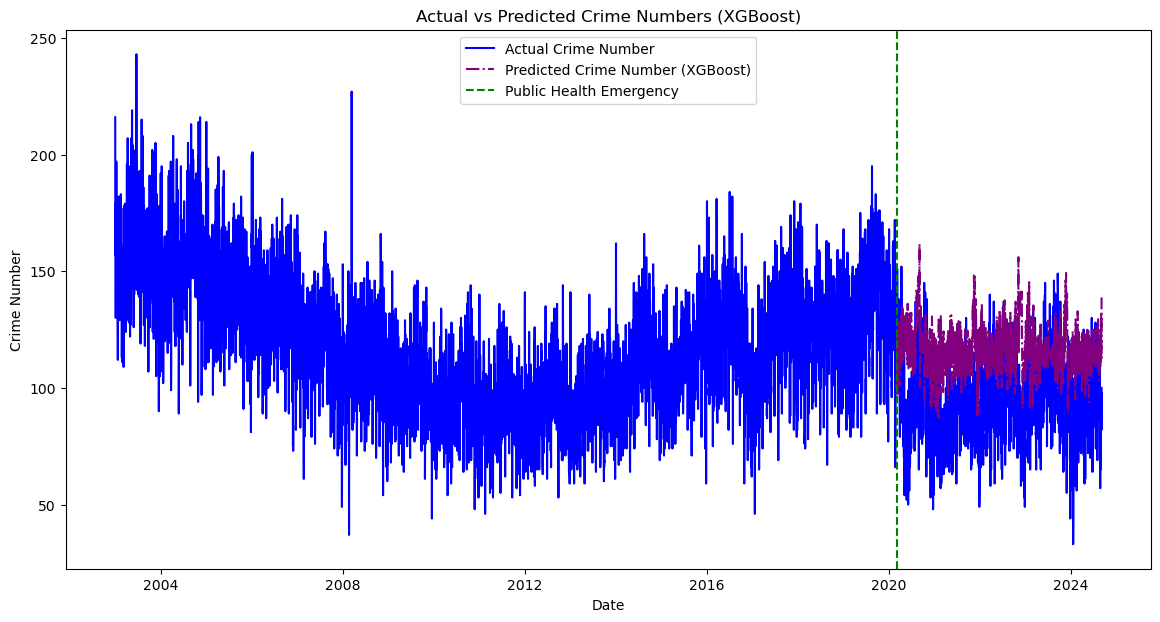

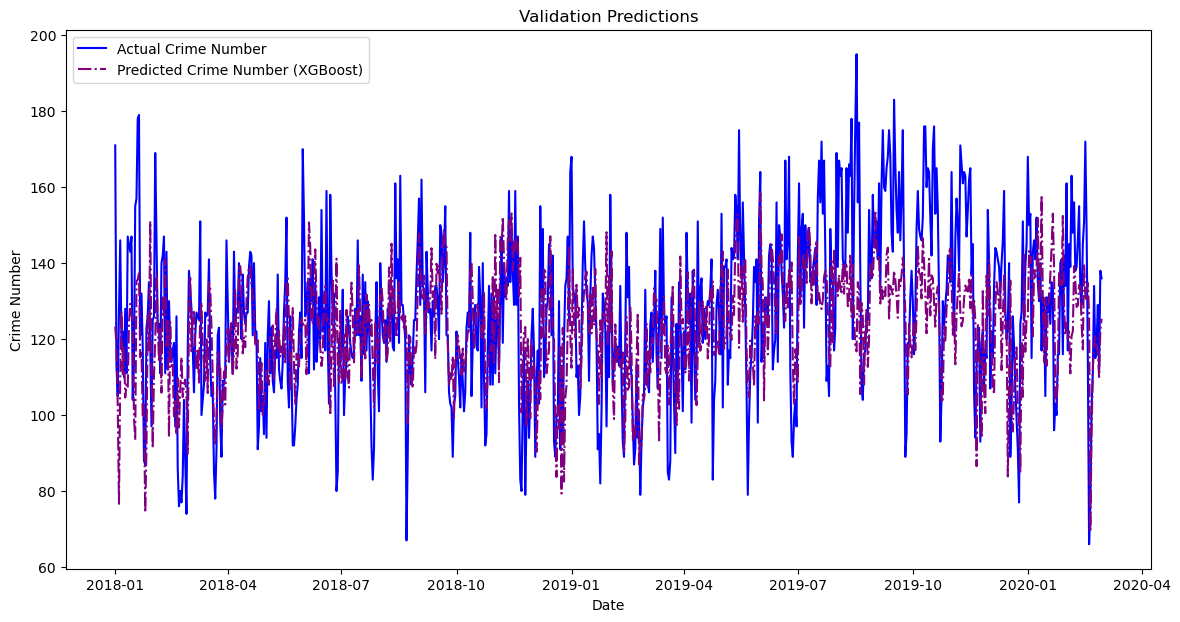

In [89]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to create lagged features
def create_lagged_features(df, target_col, lags):
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# Step 1: Prepare training, validation, and test data
pre_emergency_data = merged_df_xgb[merged_df_xgb['date'] < '2020-03-01']
pre_emergency_data = create_lagged_features(pre_emergency_data, 'crime_number', 3)
pre_emergency_data = pre_emergency_data.dropna()

# Add month and year as features
pre_emergency_data['month'] = pre_emergency_data['date'].dt.month
pre_emergency_data['year'] = pre_emergency_data['date'].dt.year

# Split data into training (before 2018), validation (2018–2020.3), and test (post-2020.3)
train_data = pre_emergency_data[pre_emergency_data['date'] < '2018-01-01']
val_data = pre_emergency_data[(pre_emergency_data['date'] >= '2018-01-01') & (pre_emergency_data['date'] < '2020-03-01')]
test_data = merged_df_xgb[merged_df_xgb['date'] >= '2020-03-01'].copy()

# Features and target columns
features = [
    'crime_number_lag_1', 'crime_number_lag_2', 'crime_number_lag_3',
    'month', 'year', 'Police officers per 100,000 population',
    'Weighted clearance rate', 'Vancouver Unemployment Rate',
    'CPI', 'MinWage', 'temperature'
]

X_train = train_data[features]
y_train = train_data['crime_number']

X_val = val_data[features]
y_val = val_data['crime_number']

# Step 2: Train the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Step 3: Evaluate performance on the validation set
val_predictions = xgb_model.predict(X_val)

# calculate mape
mape = np.mean(np.abs((y_val - val_predictions) / y_val)) * 100
print(f"Validation MAPE: {mape:.2f}%")

# Step 4: Prepare the test data
test_data = create_lagged_features(test_data, 'crime_number', 3)
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year

# Initialize list for predictions
predictions = []

# Iteratively predict crime numbers for the test period
for i in range(len(test_data)):
    X_pred = test_data[features].iloc[i].values.reshape(1, -1)
    pred = xgb_model.predict(X_pred)[0]
    predictions.append(pred)

    # Update lagged values with predictions for subsequent rows
    if i + 1 < len(test_data):
        test_data.loc[test_data.index[i + 1], 'crime_number_lag_1'] = pred
        test_data.loc[test_data.index[i + 1], 'crime_number_lag_2'] = test_data.loc[test_data.index[i], 'crime_number_lag_1']
        test_data.loc[test_data.index[i + 1], 'crime_number_lag_3'] = test_data.loc[test_data.index[i], 'crime_number_lag_2']

# Add predictions to the test data
test_data['predicted_crime_number_xgb'] = predictions

# Merge predictions back into the main dataframe
merged_df_xgb = pd.merge(merged_df_xgb, test_data[['date', 'predicted_crime_number_xgb']], how='left', on='date')

# Step 5: Plot actual vs predicted crime numbers
public_health_date = pd.to_datetime('2020-03-01')
plt.figure(figsize=(14, 7))
plt.plot(merged_df_xgb['date'], merged_df_xgb['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_xgb['date'], merged_df_xgb['predicted_crime_number_xgb'], label="Predicted Crime Number (XGBoost)", color="purple", linestyle="-.")
plt.axvline(x=public_health_date, color='green', linestyle='--', label='Public Health Emergency')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (XGBoost)")
plt.legend()
plt.show()

#plot validation predictions
plt.figure(figsize=(14, 7))
plt.plot(val_data['date'], y_val, label="Actual Crime Number", color="blue")
plt.plot(val_data['date'], val_predictions, label="Predicted Crime Number (XGBoost)", color="purple", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Validation Predictions")
plt.legend()
plt.show()


In [90]:
# do feature selection to see which combination of features has lowest mape
from itertools import combinations

# Define the features to consider
all_features = [
    'month', 'year', 'Police officers per 100,000 population',
    'Weighted clearance rate', 'Vancouver Unemployment Rate',
    'CPI', 'MinWage', 'temperature'
]

# Initialize variables to store best features and MAPE
best_mape = float('inf')
best_features = []

# Iterate over all possible feature combinations
for num_features in range(1, len(all_features) + 1):
    for feature_comb in combinations(all_features, num_features):
        X_train = train_data[list(feature_comb)]
        X_val = val_data[list(feature_comb)]

        # Train the model
        xgb_model = xgb.XGBRegressor(random_state=42)
        xgb_model.fit(X_train, y_train)

        # Make predictions
        val_predictions = xgb_model.predict(X_val)

        # Calculate MAPE
        mape = np.mean(np.abs((y_val - val_predictions) / y_val)) * 100

        # Update best MAPE and features
        if mape < best_mape:
            best_mape = mape
            best_features = list(feature_comb)

print(f"Best MAPE: {best_mape:.2f}%")
print("Best Features:", best_features)

Best MAPE: 14.08%
Best Features: ['year', 'Police officers per 100,000 population', 'Vancouver Unemployment Rate', 'CPI', 'MinWage']


Index(['date', 'MinWage', 'crime_number', 'CPI', 'temperature',
       'Police officers per 100,000 population', 'Weighted clearance rate',
       'Vancouver Unemployment Rate', 'predicted_crime_number_xgb',
       'predicted_crime_number_xgb_best_x',
       'predicted_crime_number_xgb_best_y',
       'predicted_crime_number_xgb_best_x',
       'predicted_crime_number_xgb_best_y', 'predicted_crime_number_xgb_best'],
      dtype='object')


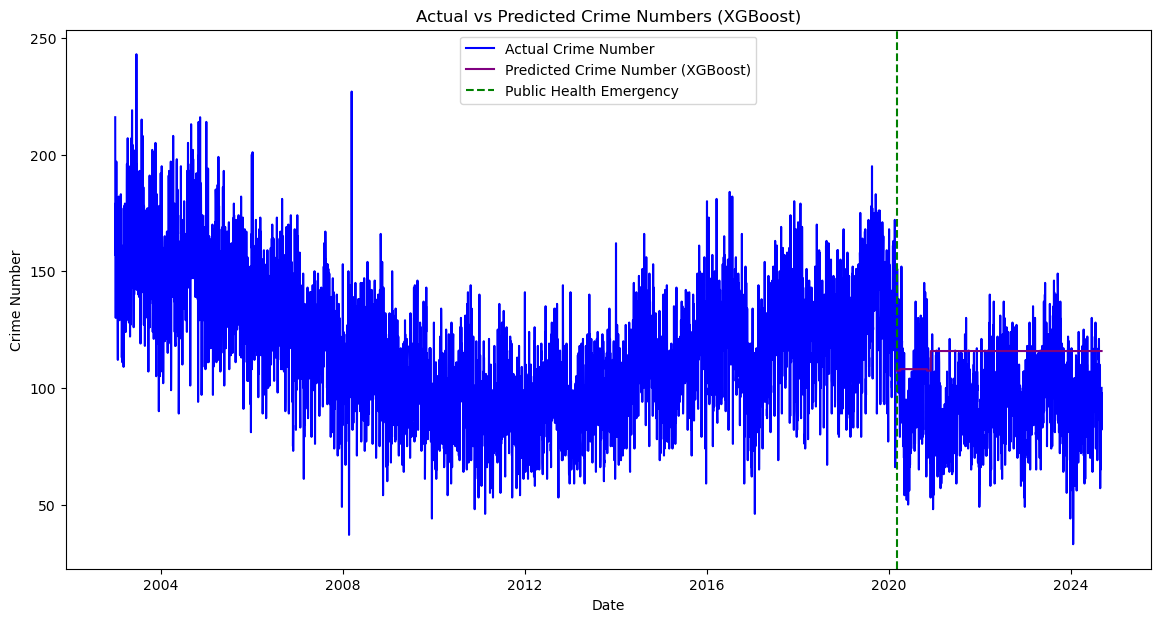

Test MAPE: 27.84%


In [96]:
# Train the final model with the best features
X_train = train_data[best_features]
X_val = val_data[best_features]
X_test = test_data[best_features]

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = xgb_model.predict(X_test)

# Add predictions to the test data
test_data['predicted_crime_number_xgb_best'] = test_predictions

# Merge predictions back into the main dataframe
merged_df_xgb = pd.merge(merged_df_xgb, test_data[['date', 'predicted_crime_number_xgb_best']], how='left', on='date')

print(merged_df_xgb.columns)

# plot predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(merged_df_xgb['date'], merged_df_xgb['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_xgb['date'], merged_df_xgb['predicted_crime_number_xgb_best'], label="Predicted Crime Number (XGBoost)", color="purple")
plt.axvline(x=public_health_date, color='green', linestyle='--', label='Public Health Emergency')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (XGBoost)")
plt.legend()
plt.show()

# print MAPE FOR test data
mape = np.mean(np.abs((test_data['crime_number'] - test_data['predicted_crime_number_xgb_best']) / test_data['crime_number'])) * 100
print(f"Test MAPE: {mape:.2f}%")
